In [5]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display

In [1]:
%matplotlib inline

In [2]:
#fly = flb.NetFly(1525,rootpath='/media/imager/FlyDataD/FlyDB/')
#fly.open_signals()

In [3]:
flynumbers = list(range(1389,1402))

In [6]:
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]

In [7]:
#l = [fly.open_signals() for fly in flylist]

In [8]:
fly = flylist[4]
fly.open_signals()

In [21]:
sorted_keys = sorted(fly.spikestates.keys())

cull_list = [('left', 'bkg'),('right', 'bkg'),
            ('left', 'iii1'),('right', 'iii1'),
            ('left', 'iii24'),('right', 'iii24'),
            ('left', 'hg2'),('right', 'hg2'),
            ('left', 'hg3'),('right', 'hg3'),
            ('left', 'hg4'),('right', 'hg4'),
            ('left', 'nm'),('right', 'nm'),
            ('left', 'pr'),('right', 'pr'),
            ('left', 'tpd'),('right', 'tpd')]
for cull in cull_list:
    sorted_keys.remove(cull)
#[sorted_keys.remove(cull) for cull in cull_list]

In [22]:
state_mtrx = np.vstack([fly.spikestates[key] for key in sorted_keys])

In [32]:
len(sorted_keys)

14

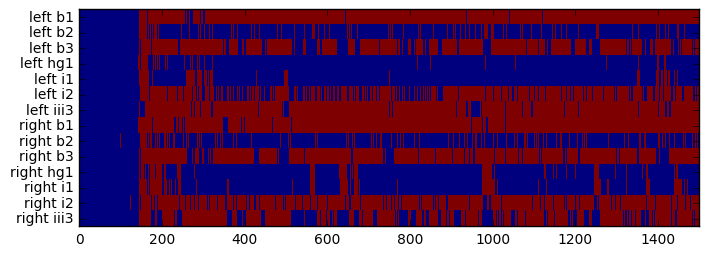

In [36]:
plt.figure(figsize = (8,2.8))
plt.imshow(state_mtrx[:,500:2000],aspect = 'auto',interpolation = 'nearest')
plt.gca().set_yticks(range(14))
lbs = plt.gca().set_yticklabels(['%s %s'%k for k in sorted_keys])   

In [38]:
byte_vector = [2**i for i in range(len(sorted_keys))]

In [44]:
int_rep = np.dot(np.array(byte_vector),state_mtrx)

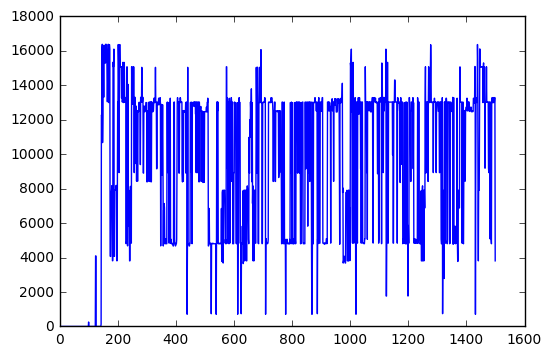

In [45]:
plt.plot(int_rep[500:2000])

In [46]:
unique_states,indxs,inv_indx,counts = np.unique(int_rep,return_index=True,return_inverse = True,return_counts=True)

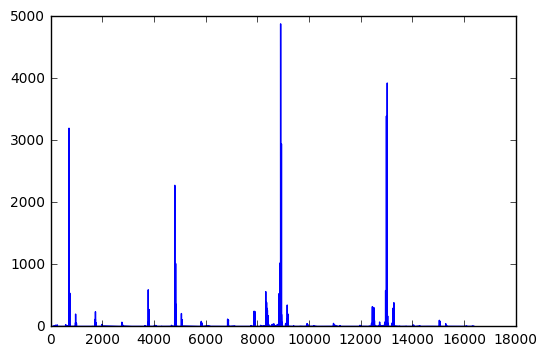

In [47]:
byte_vector = [2**i for i in range(len(sorted_keys))]

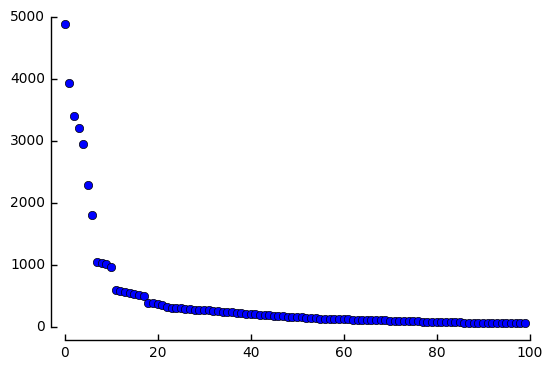

In [58]:
sort_idx = np.argsort(counts)[::-1]
#only a few motor states are common
plt.plot(counts[sort_idx][:100],'o',clip_on = False)
fifi.mpl_functions.adjust_spines(plt.gca(),['left','bottom'])

In [59]:
common_state_vector = unique_states[sort_idx][:100]
common_states_bin = ['%014d'%np.int(np.binary_repr(x)) for x in common_state_vector]
common_states_bin = np.array([np.array(list(x)).astype('int') for x in common_states_bin])

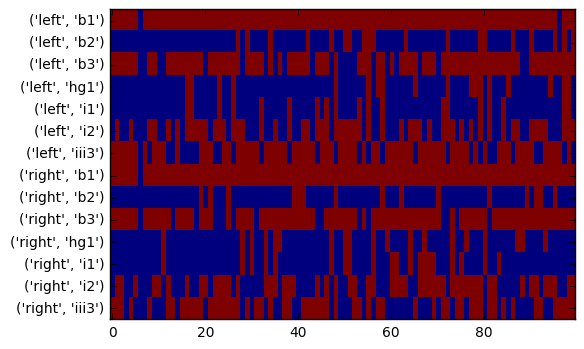

In [60]:
plt.imshow(common_states_bin.T[::-1,:100],aspect = 'auto',interpolation = 'nearest')
lbs = plt.gca().set_yticks(range(0,14))
lbs = plt.gca().set_yticklabels(sorted_keys)

In [64]:
tmtrx = np.zeros((2**14,2**14),dtype = np.int)

In [65]:
for idx0,idx1 in zip(int_rep[:-1],int_rep[1:]):
    tmtrx[idx0,idx1] += 1

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [ ]:
plt.imshow(tmtrx)